In [ ]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


This project was executed with data gathered from University of Toronto CSC321 class in 2020. The main objective here was to determine whether an image of a shoe is the left or right shoe. The original picture dimension is 244 x 244 pixels.

Loading the training and test data, and separating the training data into training and validation.
Creating the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of students allocated to train, valid, or test
- `3` - the 3 pairs of shoes submitted by that student
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image submitted
by the 5th student.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair. 
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair, submitted by
the same student.

In [ ]:

import glob
path = "/content/gdrive/My Drive/CSC321/data/train/*.jpg"

files = {}
num_img = 0
max_stud = 0

for file in glob.glob(path):              #sorting the paths to save time
  num_img+=1
  filename = file.split("/")[-1]
  parms = filename.split("_")[0:3]
  stud = int(parms[0].split("u")[-1])
  pair = int(parms[1])-1
  
  if(parms[2] == "left"):
    lr = 0
  else:
    lr = 1 
  if stud not in files:
    files[stud] = [0,0,0,0,0,0]
  if stud > max_stud:
    max_stud = stud
  files[stud][2*pair + lr] = file
  
num_student = int(num_img/6)
train_data = np.zeros((int(num_student*0.8),3, 2, 224, 224, 3), dtype=int)
valid_data = np.zeros((int(num_student*0.21),3, 2, 224, 224, 3), dtype=int)
cur_stud_1 = 0 
cur_stud_2 = 0 
num_train = int(num_student*0.79)
num_valid = int(num_student*0.21)
for i in range(max_stud):
  if(i in files):
    if (cur_stud_1 <= num_train):
      for s in range(3):
        for l in range(2):
          filename = files[i][2*s+l]
          img = plt.imread(filename)           
          train_data[cur_stud_1,s,l,:,:,:] = img[:, :, :3].astype(int)
      cur_stud_1 += 1
    else:
      for s in range(3):
        for l in range(2):
          filename = files[i][2*s+l]
          img = plt.imread(filename)           
          valid_data[cur_stud_2,s,l,:,:,:] = img[:, :, :3].astype(int)
      cur_stud_1 += 1
      cur_stud_2 += 1

np.save("/content/gdrive/My Drive/CSC321/data/train_data.npy",train_data)
np.save("/content/gdrive/My Drive/CSC321/data/valid_data.npy",valid_data)
    

In [ ]:
train_data = np.load("/content/gdrive/My Drive/CSC321/data/train_data.npy")
valid_data = np.load("/content/gdrive/My Drive/CSC321/data/valid_data.npy")

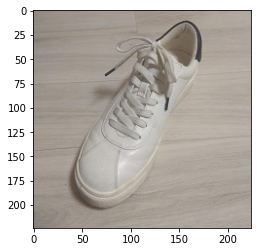

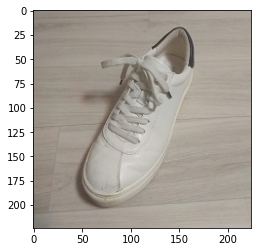

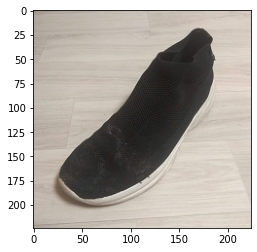

In [ ]:
# Run this code, include the image in your PDF submission
plt.figure()
plt.imshow(train_data[4,0,0,:,:,:]) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:]) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:]) # right shoe of second pair submitted by 5th student

Here, we wrote helper functions to help us with image manipulation and image generation.

In [ ]:
def concat(up, down):
  img = np.zeros((448, 224, 3), dtype=int)
  img[:224,:,:] = up
  img[224:,:,:] = down
  return img

#plt.imshow(concat(train_data[23,0,0,:,:,:],train_data[23,0,1,:,:,:]))

def generate_same_pair(data):
  N = data.shape[0]
  same_pair = np.zeros((3*N, 448,224,3), dtype= int)

  for i in range(N):
    
    same_pair[3*i] = concat(data[i,0,0,:,:,:],data[i,0,1,:,:,:])
    same_pair[3*i+1] = concat(data[i,1,0,:,:,:],data[i,1,1,:,:,:])
    same_pair[3*i+2] = concat(data[i,2,0,:,:,:],data[i,2,1,:,:,:])

  return same_pair

def generate_different_pair(data):
  N = data.shape[0]
  different_pair = np.zeros((3*N, 448,224,3), dtype= int)

  for i in range(N):
    
    different_pair[3*i] = concat(data[i,0,0,:,:,:],data[i,1,1,:,:,:])
    different_pair[3*i+1] = concat(data[i,1,0,:,:,:],data[i,2,1,:,:,:])
    different_pair[3*i+2] = concat(data[i,2,0,:,:,:],data[i,0,1,:,:,:])

  return different_pair


(89, 3, 2, 224, 224, 3)
(267, 448, 224, 3)


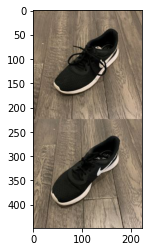

In [ ]:
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_same_pair(train_data)[0]) # should show 2 shoes from the same pair

(89, 3, 2, 224, 224, 3)
(267, 448, 224, 3)


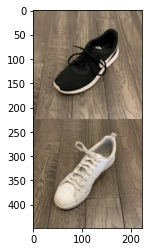

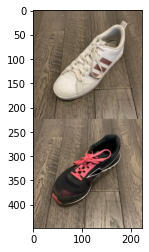

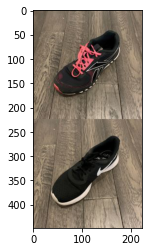

In [ ]:
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
different_pair = generate_different_pair(train_data)
print(different_pair.shape) # should be [N*3, 448, 224, 3]

plt.figure()
plt.imshow(different_pair[0]) # should show 2 shoes from different pairs

plt.figure()
plt.imshow(different_pair[1]) # should show 2 shoes from different pairs

plt.figure()
plt.imshow(different_pair[2]) # should show 2 shoes from different pairs

# CONVOLUTIONAL NEURAL NETWORKS

Here, we defined the CNN class with appropriate layers and implemented the forward pass.

In [ ]:
class CNN(nn.Module):
    def __init__(self, n = 4):
        
        super(CNN, self).__init__()
        self.n = n
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=n, out_channels=2*n, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=2*n, out_channels=4*n, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=4*n, out_channels=8*n, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(8*n*28*14, 100)
        self.fc2 = nn.Linear(100, 2)
        self.fc3 = nn.Linear(2, 1)

    def forward(self, x):
      #3x448x224
      x = self.pool(torch.relu(self.conv1(x.float())))
      #nx224x112
      x = self.pool(torch.relu(self.conv2(x.float())))
      #2nx112*56
      x = self.pool(torch.relu(self.conv3(x.float())))
      #4nx56x28
      x = self.pool(torch.relu(self.conv4(x.float())))
      #8nx28x14
      x = x.view(-1, 8*self.n *28*14)
      x = self.fc1(x)
      x = self.fc2(x)
      return x 


In [ ]:
#test
model = CNN()
x = torch.rand((1,3,448,224))
model.forward(x).shape


torch.Size([1, 3, 448, 224])


torch.Size([1, 2])

### Part (b) -- 4 pts

Implementing a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the pervious implementation, but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://www.cs.toronto.edu/~lczhang/321/hw/p3model.png" width="400px" />


In [ ]:
class CNNChannel(nn.Module):
    def __init__(self, n=4):
        super(CNNChannel, self).__init__()
        # TODO: complete this method
        self.n = n
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(in_channels=6, out_channels=n, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=n, out_channels=2*n, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=2*n, out_channels=4*n, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=4*n, out_channels=8*n, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(4*n*28*14, 100)
        self.fc2 = nn.Linear(100, 2)
    
    def forward(self, x):
      img = np.zeros((32,224,224,6), dtype=int)
      up = np.zeros((32,224, 224, 3), dtype=int)
      down = np.zeros((32,224, 224, 3), dtype=int)
      down = x[:,:,224:,:]
      up = x[:,:,:224,:]


      img = torch.cat((up,down),dim = 1)
      x = img
      x = self.pool(torch.relu(self.conv1(x.float())))
      x = self.pool(torch.relu(self.conv2(x.float())))
      x = self.pool(torch.relu(self.conv3(x.float())))
      x = self.pool(torch.relu(self.conv4(x.float())))
      x = x.view(-1, 8*self.n *14*14)
      x = self.fc1(x)

      x = self.fc2(x)
      
      return x 

        



In [ ]:
#test
model = CNNChannel()
x = torch.rand((1,3,448,224))
model.forward(x)


In [ ]:
def get_accuracy(model, data, batch_size=50):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).view((-1,3,448,224))
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        pos_correct += (pred == 1).sum()
    
    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).view((-1,3,448,224))
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

In [ ]:
def save_checkpoint(state, is_best, filename='/content/gdrive/My Drive/CSC321/data/checkpoint.pth.tar'):
    if is_best:
        torch.save(state, filename)  # save checkpoint

# Training the Model


In [ ]:
def train_model(model, train_data, valid_data, batch_size=64, weight_decay=10,
          learning_rate=0.1, num_epochs=30,tot_plot = False, neg_plot = False,
                pos_plot = False , loss_plot = False, verbose = False):
     
    # loss function
    criterion = nn.CrossEntropyLoss()
    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay)


    #Diffrent pair training
    df_pair = torch.tensor(generate_different_pair(train_data)).view((-1,3,448,224))
    df_label = torch.zeros((df_pair.shape[0]),dtype=int)

    #Same pair training
    sm_pair = torch.tensor(generate_same_pair(train_data)).view((-1,3,448,224))
    sm_label = torch.ones((df_pair.shape[0]),dtype=int)

    #Diffrent pair training
    df_pair_val = torch.tensor(generate_different_pair(valid_data)).view((-1,3,448,224))
    df_label_val = torch.zeros((df_pair.shape[0]),dtype=int)

    #Same pair validation
    sm_pair_val = torch.tensor(generate_same_pair(valid_data)).view((-1,3,448,224))
    sm_label_val = torch.ones((df_pair.shape[0]),dtype=int)

    

    imgs = torch.cat((df_pair, sm_pair), 0)
    labels = torch.cat((df_label, sm_label), 0)
    imgs_val = torch.cat((df_pair_val, sm_pair_val), 0)
    labels_val = torch.cat((df_label_val, sm_label_val), 0)
  
    data = TensorDataset(imgs,labels)
    acc_list = []
    val_acc_neg = []
    val_acc_pos = []
    tot_val_acc = []
    tot_train_acc = []
    best_accuracy = 0
    loss = 0
    correct = 0
    # track learning curve
    iters, losses, train_acc_pos, train_acc_neg = [], [], [], []
    # training
    n = 0 # the number of iterations (for plotting)
    i = 0
    train_loader = torch.utils.data.DataLoader(data,batch_size=batch_size,shuffle=True, drop_last=True)
    for epoch in range(num_epochs):
        #shuffle training 
        for i, (images, labels) in enumerate(train_loader):
            # Run the forward pass

            model.train()
            out = model(images)
            loss = criterion(out, labels)

            # Backprop and perform Adam optimisation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            n+=1
          
        loss = float(loss)/batch_size
        tacc = get_accuracy(model, train_data)
        vacc = get_accuracy(model, valid_data)
        if (verbose):
          print("Iter %d; Loss %f; Train Acc neg %.3f; Train Acc pos %.3f; Total Acc %.3f" % (n, loss, tacc[0], tacc[1], (tacc[0]+tacc[1])/2))
        
        iters.append(n)
        losses.append(loss)
        val_acc_neg.append(vacc[0])
        val_acc_pos.append(vacc[1])

        train_acc_pos.append(tacc[1])
        train_acc_neg.append(tacc[0])

        tot_val_acc.append((vacc[0]+vacc[1])/2)
        tot_train_acc.append((tacc[0]+tacc[1])/2)

        #Checkpointing
        if (best_accuracy < tot_val_acc[-1]):
          best_accuracy = tot_val_acc[-1]
          print("Best Accuracy:" + str(best_accuracy))
          torch.save(model.state_dict(), '/content/gdrive/My Drive/CSC321/data/checkpoint.pth.tar')

      
    plt.figure()
    # plotting
    if (loss_plot):
      plt.subplot(2,2,1)
      plt.title("Loss Curve")
      plt.plot(iters, losses, label="Train")
      plt.xlabel("Iterations")
      plt.ylabel("Loss")
      #plt.show()

    if (neg_plot):
      plt.subplot(2,2,2)
      plt.title("Accuracy Curve Negative")
      plt.plot(iters,train_acc_neg, label="Train")
      plt.plot(iters,val_acc_neg, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Training Accuracy")
      plt.legend(loc='best')
      #plt.show()

    if (pos_plot):
      plt.subplot(2,2,3)
      plt.title("Accuracy Curve Positive")
      plt.plot(iters,train_acc_pos, label="Train")
      plt.plot(iters,val_acc_pos, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Training Accuracy")
      plt.legend(loc='best')
      #plt.show()

    if (tot_plot):
      plt.subplot(2,2,4)
      plt.title("Accuracy Curve Total")
      plt.plot(iters,tot_train_acc, label="Train")
      plt.plot(iters,tot_val_acc, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Training Accuracy")
      plt.legend(loc='best')
      #plt.show()


    plt.show()
    if (verbose):
      print("Final Negative Training Accuracy: {}".format(train_acc_neg[-1]))
      print("Final Negative Validation Accuracy: {}".format(val_acc_neg[-1]))
      print("Final Positive Training Accuracy: {}".format(train_acc_pos[-1]))
      print("Final Positive Validation Accuracy: {}".format(val_acc_pos[-1]))
        

        
       
        
        

Iter 1; Loss 0.135176; Train Acc neg 0.000; Train Acc pos 1.000; Total Acc 0.500
Best Accuracy:0.5
Iter 2; Loss 5.218739; Train Acc neg 0.000; Train Acc pos 1.000; Total Acc 0.500
Iter 3; Loss 2.950962; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Iter 4; Loss 0.296702; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Iter 5; Loss 0.982965; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Iter 6; Loss 0.278286; Train Acc neg 0.000; Train Acc pos 1.000; Total Acc 0.500
Iter 7; Loss 1.009324; Train Acc neg 0.000; Train Acc pos 1.000; Total Acc 0.500
Iter 8; Loss 1.279966; Train Acc neg 0.000; Train Acc pos 1.000; Total Acc 0.500
Iter 9; Loss 0.804361; Train Acc neg 1.000; Train Acc pos 0.667; Total Acc 0.833
Iter 10; Loss 0.049661; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Iter 11; Loss 0.607572; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Iter 12; Loss 0.603027; Train Acc neg 1.000; Train Acc pos 0.333; Total Acc 0.667
Iter 13

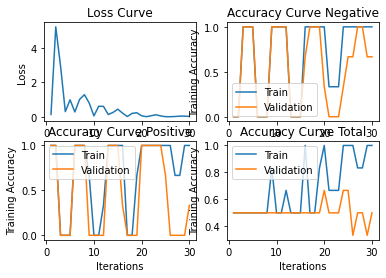

Final Negative Training Accuracy: 1.0
Final Negative Validation Accuracy: 0.6666666666666666
Final Positive Training Accuracy: 1.0
Final Positive Validation Accuracy: 0.3333333333333333


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

model = CNN(8)
td = train_data[:1]
vd = valid_data[:1]
train_model(model, td, vd, batch_size=6, weight_decay=0.01,
          learning_rate=0.0001, num_epochs=30 ,loss_plot = True, neg_plot= True, pos_plot = True, tot_plot = True, verbose = True)




In [ ]:
model2 = CNNChannel(8)
model2.load_state_dict(torch.load('/content/gdrive/My Drive/CSC321/data/best_acc.tar'))

tacc = get_accuracy(model2, train_data, batch_size=64)
vacc = get_accuracy(model2, valid_data, batch_size=64)

print("Total Validation Acc %.3f" % ((vacc[0]+vacc[1])/2))
print("Total Train Acc %.3f" % ((tacc[0]+tacc[1])/2))




Total Validation Acc 0.710
Total Train Acc 0.904


Iter 16; Loss 0.042379; Train Acc neg 0.670; Train Acc pos 0.438


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Iter 32; Loss 0.023008; Train Acc neg 0.704; Train Acc pos 0.438
Iter 48; Loss 0.021022; Train Acc neg 0.401; Train Acc pos 0.727
Iter 64; Loss 0.018754; Train Acc neg 0.757; Train Acc pos 0.509
Iter 80; Loss 0.028060; Train Acc neg 1.000; Train Acc pos 0.052
Iter 96; Loss 0.027146; Train Acc neg 0.584; Train Acc pos 0.697
Iter 112; Loss 0.015848; Train Acc neg 1.000; Train Acc pos 0.090
Iter 128; Loss 0.018728; Train Acc neg 0.341; Train Acc pos 0.955
Iter 144; Loss 0.021260; Train Acc neg 0.809; Train Acc pos 0.652
Iter 160; Loss 0.015862; Train Acc neg 0.749; Train Acc pos 0.798
Iter 176; Loss 0.017830; Train Acc neg 0.936; Train Acc pos 0.588
Iter 192; Loss 0.015930; Train Acc neg 0.993; Train Acc pos 0.419
Iter 208; Loss 0.013935; Train Acc neg 0.985; Train Acc pos 0.427
Iter 224; Loss 0.018015; Train Acc neg 0.506; Train Acc pos 0.959
Iter 240; Loss 0.012973; Train Acc neg 0.689; Train Acc pos 0.948
Iter 256; Loss 0.016618; Train Acc neg 0.491; Train Acc pos 0.981
Iter 272; Loss 

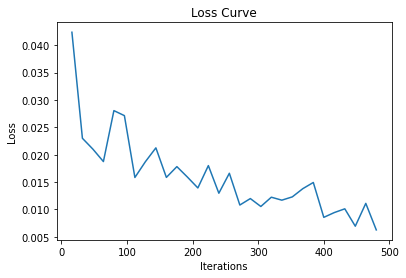

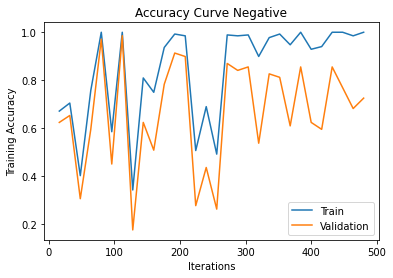

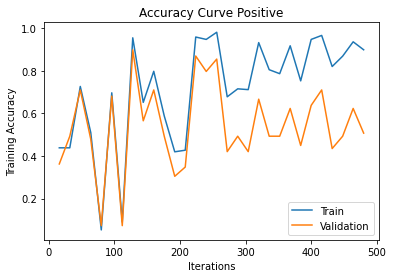

Final Negative Training Accuracy: 1.0
Final Negative Validation Accuracy: 0.7246376811594203
Final Positive Training Accuracy: 0.898876404494382
Final Positive Validation Accuracy: 0.5072463768115942
Final Total Training Accuracy: 0.0


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

model = CNNChannel()

train_model(model, train_data, valid_data, batch_size=32, weight_decay=0.01,
          learning_rate=0.0001, num_epochs=30 ,loss_plot = True, neg_plot= True, pos_plot = True)

In [ ]:
for i in range(4,20,4):
  model = CNN(i)
  plt.subplot(2,2,(i//4))
  plt.title(" Learning Rate:" +str(lr))
  train_model(model, train_data[0:64], batch_size=16, weight_decay=10,
          learning_rate=0.01, num_epochs=30)
  
plt.tight_layout()
plt.show()

Iter 1; Loss 0.148296; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Best Accuracy:0.5
Iter 2; Loss 1.508027; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Iter 3; Loss 0.982133; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Iter 4; Loss 0.105241; Train Acc neg 0.000; Train Acc pos 1.000; Total Acc 0.500
Iter 5; Loss 0.772815; Train Acc neg 0.000; Train Acc pos 1.000; Total Acc 0.500
Iter 6; Loss 0.982554; Train Acc neg 0.000; Train Acc pos 1.000; Total Acc 0.500
Iter 7; Loss 0.810785; Train Acc neg 0.000; Train Acc pos 1.000; Total Acc 0.500
Iter 8; Loss 0.406387; Train Acc neg 1.000; Train Acc pos 0.667; Total Acc 0.833
Best Accuracy:0.6666666666666666
Iter 9; Loss 0.066874; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Iter 10; Loss 0.377893; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Iter 11; Loss 0.484277; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Iter 12; Loss 0.380134; Train Acc neg 1.000; Train Acc p

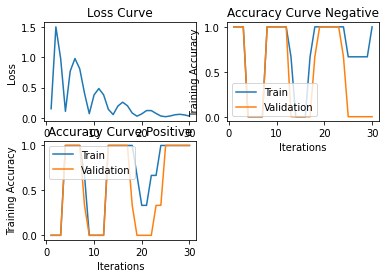

Final Negative Training Accuracy: 1.0
Final Negative Validation Accuracy: 0.0
Final Positive Training Accuracy: 1.0
Final Positive Validation Accuracy: 1.0


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

model = CNN()

train_model(model, train_data[:1], valid_data[:1], batch_size=6, weight_decay=0.01,
          learning_rate=0.0001, num_epochs=30 ,loss_plot = True, neg_plot= True, pos_plot = True, verbose = True)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset


Iter 8; Loss 0.036375; Train Acc neg 0.000; Train Acc pos 1.000; Total Acc 0.500
Best Accuracy:0.5
Iter 16; Loss 0.237852; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Iter 24; Loss 0.022462; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Iter 32; Loss 0.011095; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Iter 40; Loss 0.036736; Train Acc neg 0.985; Train Acc pos 0.056; Total Acc 0.521
Best Accuracy:0.5072463768115942
Iter 48; Loss 0.019098; Train Acc neg 0.007; Train Acc pos 0.989; Total Acc 0.498
Iter 56; Loss 0.016816; Train Acc neg 0.513; Train Acc pos 0.521; Total Acc 0.517
Iter 64; Loss 0.010737; Train Acc neg 0.712; Train Acc pos 0.360; Total Acc 0.536
Best Accuracy:0.5217391304347826
Iter 72; Loss 0.011734; Train Acc neg 0.978; Train Acc pos 0.064; Total Acc 0.521
Iter 80; Loss 0.013216; Train Acc neg 0.007; Train Acc pos 1.000; Total Acc 0.504
Iter 88; Loss 0.014975; Train Acc neg 0.966; Train Acc pos 0.086; Total Acc 0.526
Iter 96; Loss 0

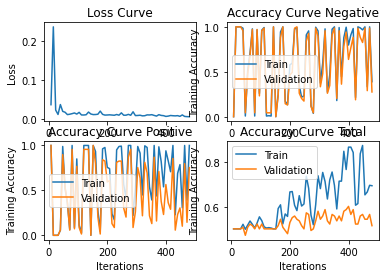

Final Negative Training Accuracy: 0.3895131086142322
Final Negative Validation Accuracy: 0.2753623188405797
Final Positive Training Accuracy: 1.0
Final Positive Validation Accuracy: 0.7536231884057971


<Figure size 432x288 with 0 Axes>

In [ ]:

model = CNN(4)
  
train_model(model, train_data,valid_data, batch_size=64, weight_decay=0.01,
        learning_rate=0.0001, num_epochs=60, loss_plot = True, neg_plot= True, pos_plot = True, tot_plot = True, verbose = True)
  
plt.tight_layout()
plt.show()

Iter 8; Loss 0.113394; Train Acc neg 0.536; Train Acc pos 0.509; Total Acc 0.522
Best Accuracy:0.5144927536231885
Iter 16; Loss 0.061459; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Iter 24; Loss 0.021239; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Iter 32; Loss 0.016202; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Iter 40; Loss 0.011406; Train Acc neg 1.000; Train Acc pos 0.019; Total Acc 0.509
Iter 48; Loss 0.010872; Train Acc neg 0.981; Train Acc pos 0.142; Total Acc 0.562
Iter 56; Loss 0.010534; Train Acc neg 0.985; Train Acc pos 0.172; Total Acc 0.579
Best Accuracy:0.5217391304347826
Iter 64; Loss 0.011215; Train Acc neg 0.371; Train Acc pos 0.918; Total Acc 0.644
Best Accuracy:0.5289855072463768
Iter 72; Loss 0.009439; Train Acc neg 0.625; Train Acc pos 0.884; Total Acc 0.755
Best Accuracy:0.6376811594202899
Iter 80; Loss 0.009537; Train Acc neg 0.303; Train Acc pos 0.989; Total Acc 0.646
Iter 88; Loss 0.007772; Train Acc neg 0.457; Trai

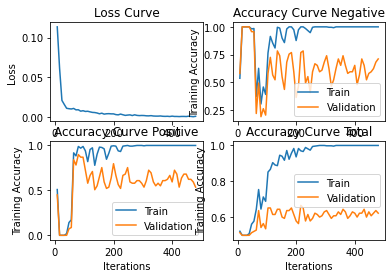

Final Negative Training Accuracy: 1.0
Final Negative Validation Accuracy: 0.7101449275362319
Final Positive Training Accuracy: 1.0
Final Positive Validation Accuracy: 0.5362318840579711


<Figure size 432x288 with 0 Axes>

In [ ]:

model = CNN(8)
  
train_model(model, train_data,valid_data, batch_size=64, weight_decay=0.01,
        learning_rate=0.0001, num_epochs=60, loss_plot = True, neg_plot= True, pos_plot = True, tot_plot = True, verbose = True)
  
plt.tight_layout()
plt.show()

Iter 8; Loss 0.079031; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Best Accuracy:0.5
Iter 16; Loss 0.016175; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Iter 24; Loss 0.021919; Train Acc neg 0.000; Train Acc pos 1.000; Total Acc 0.500
Iter 32; Loss 0.015784; Train Acc neg 0.989; Train Acc pos 0.112; Total Acc 0.551
Iter 40; Loss 0.010371; Train Acc neg 0.610; Train Acc pos 0.596; Total Acc 0.603
Best Accuracy:0.5652173913043479
Iter 48; Loss 0.009966; Train Acc neg 0.169; Train Acc pos 0.948; Total Acc 0.558
Iter 56; Loss 0.010648; Train Acc neg 0.993; Train Acc pos 0.142; Total Acc 0.567
Iter 64; Loss 0.010151; Train Acc neg 0.393; Train Acc pos 0.933; Total Acc 0.663
Iter 72; Loss 0.008991; Train Acc neg 0.697; Train Acc pos 0.846; Total Acc 0.772
Best Accuracy:0.5942028985507246
Iter 80; Loss 0.009465; Train Acc neg 0.959; Train Acc pos 0.521; Total Acc 0.740
Iter 88; Loss 0.008374; Train Acc neg 0.963; Train Acc pos 0.581; Total Acc 0.772
Iter 96; Loss 0

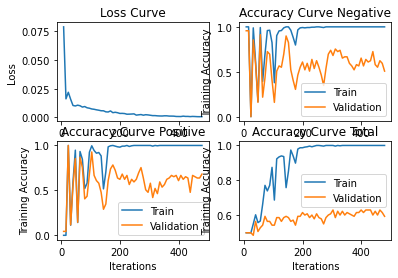

Final Negative Training Accuracy: 1.0
Final Negative Validation Accuracy: 0.5072463768115942
Final Positive Training Accuracy: 1.0
Final Positive Validation Accuracy: 0.6811594202898551


<Figure size 432x288 with 0 Axes>

In [ ]:
model = CNN(6)
  
train_model(model, train_data,valid_data, batch_size=64, weight_decay=0.01,
        learning_rate=0.0001, num_epochs=60, loss_plot = True, neg_plot= True, pos_plot = True, tot_plot = True, verbose = True)
  
plt.tight_layout()
plt.show()

Iter 8; Loss 0.025981; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Best Accuracy:0.5
Iter 16; Loss 0.022763; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Iter 24; Loss 0.015091; Train Acc neg 0.000; Train Acc pos 1.000; Total Acc 0.500
Iter 32; Loss 0.010423; Train Acc neg 0.457; Train Acc pos 0.678; Total Acc 0.567
Best Accuracy:0.5579710144927537
Iter 40; Loss 0.010565; Train Acc neg 0.974; Train Acc pos 0.127; Total Acc 0.551
Iter 48; Loss 0.009862; Train Acc neg 0.296; Train Acc pos 0.906; Total Acc 0.601
Iter 56; Loss 0.010400; Train Acc neg 0.816; Train Acc pos 0.532; Total Acc 0.674
Best Accuracy:0.6159420289855072
Iter 64; Loss 0.009707; Train Acc neg 0.903; Train Acc pos 0.464; Total Acc 0.684
Iter 72; Loss 0.009401; Train Acc neg 0.985; Train Acc pos 0.300; Total Acc 0.642
Iter 80; Loss 0.010211; Train Acc neg 0.034; Train Acc pos 1.000; Total Acc 0.517
Iter 88; Loss 0.010744; Train Acc neg 0.854; Train Acc pos 0.682; Total Acc 0.768
Iter 96; Loss 0

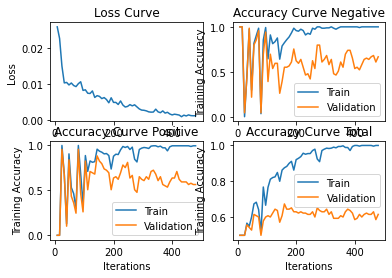

Final Negative Training Accuracy: 1.0
Final Negative Validation Accuracy: 0.6666666666666666
Final Positive Training Accuracy: 0.9962546816479401
Final Positive Validation Accuracy: 0.5652173913043478


<Figure size 432x288 with 0 Axes>

In [ ]:
model = CNNChannel(6)
  
train_model(model, train_data,valid_data, batch_size=64, weight_decay=0.01,
        learning_rate=0.0001, num_epochs=60, loss_plot = True, neg_plot= True, pos_plot = True, tot_plot = True, verbose = True)
  
plt.tight_layout()
plt.show()

Iter 8; Loss 0.011492; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Best Accuracy:0.5
Iter 16; Loss 0.028764; Train Acc neg 0.000; Train Acc pos 1.000; Total Acc 0.500
Iter 24; Loss 0.010533; Train Acc neg 0.000; Train Acc pos 1.000; Total Acc 0.500
Iter 32; Loss 0.015126; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Iter 40; Loss 0.010534; Train Acc neg 0.933; Train Acc pos 0.105; Total Acc 0.519
Best Accuracy:0.5217391304347826
Iter 48; Loss 0.012568; Train Acc neg 0.000; Train Acc pos 1.000; Total Acc 0.500
Iter 56; Loss 0.010715; Train Acc neg 0.412; Train Acc pos 0.663; Total Acc 0.537
Best Accuracy:0.5434782608695652
Iter 64; Loss 0.010590; Train Acc neg 0.667; Train Acc pos 0.438; Total Acc 0.552
Iter 72; Loss 0.010756; Train Acc neg 0.041; Train Acc pos 0.985; Total Acc 0.513
Iter 80; Loss 0.011070; Train Acc neg 0.933; Train Acc pos 0.161; Total Acc 0.547
Iter 88; Loss 0.010820; Train Acc neg 0.996; Train Acc pos 0.030; Total Acc 0.513
Iter 96; Loss 0

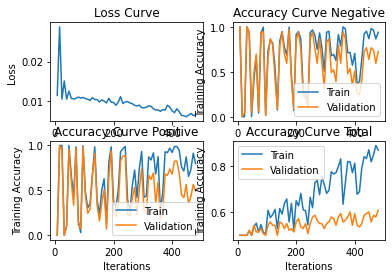

Final Negative Training Accuracy: 0.9400749063670412
Final Negative Validation Accuracy: 0.7246376811594203
Final Positive Training Accuracy: 0.797752808988764
Final Positive Validation Accuracy: 0.4927536231884058


<Figure size 432x288 with 0 Axes>

In [ ]:
model = CNNChannel()
  
train_model(model, train_data,valid_data, batch_size=64, weight_decay=0.01,
        learning_rate=0.0001, num_epochs=60, loss_plot = True, neg_plot= True, pos_plot = True, tot_plot = True, verbose = True)
  
plt.tight_layout()
plt.show()

Iter 8; Loss 0.055073; Train Acc neg 0.000; Train Acc pos 1.000; Total Acc 0.500
Best Accuracy:0.5
Iter 16; Loss 0.022442; Train Acc neg 0.049; Train Acc pos 0.966; Total Acc 0.507
Iter 24; Loss 0.018564; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Iter 32; Loss 0.012458; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Iter 40; Loss 0.011304; Train Acc neg 0.993; Train Acc pos 0.075; Total Acc 0.534
Iter 48; Loss 0.010221; Train Acc neg 0.921; Train Acc pos 0.251; Total Acc 0.586
Best Accuracy:0.5289855072463768
Iter 56; Loss 0.010460; Train Acc neg 0.869; Train Acc pos 0.393; Total Acc 0.631
Best Accuracy:0.5652173913043479
Iter 64; Loss 0.010607; Train Acc neg 0.468; Train Acc pos 0.787; Total Acc 0.627
Iter 72; Loss 0.009704; Train Acc neg 0.787; Train Acc pos 0.618; Total Acc 0.702
Iter 80; Loss 0.010150; Train Acc neg 0.554; Train Acc pos 0.813; Total Acc 0.684
Iter 88; Loss 0.009814; Train Acc neg 0.685; Train Acc pos 0.772; Total Acc 0.728
Best Accuracy:0

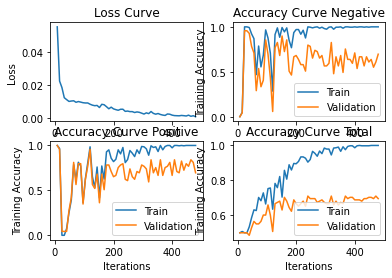

Final Negative Training Accuracy: 1.0
Final Negative Validation Accuracy: 0.6956521739130435
Final Positive Training Accuracy: 1.0
Final Positive Validation Accuracy: 0.6956521739130435


<Figure size 432x288 with 0 Axes>

In [ ]:
model = CNNChannel(8)
  
train_model(model, train_data,valid_data, batch_size=64, weight_decay=0.01,
        learning_rate=0.0001, num_epochs=60, loss_plot = True, neg_plot= True, pos_plot = True, tot_plot = True, verbose = True)
  
plt.tight_layout()
plt.show()

Iter 8; Loss 0.159982; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Best Accuracy:0.5
Iter 16; Loss 0.035287; Train Acc neg 0.000; Train Acc pos 1.000; Total Acc 0.500
Iter 24; Loss 0.015225; Train Acc neg 0.004; Train Acc pos 1.000; Total Acc 0.502
Iter 32; Loss 0.011036; Train Acc neg 1.000; Train Acc pos 0.004; Total Acc 0.502
Best Accuracy:0.5144927536231884
Iter 40; Loss 0.011601; Train Acc neg 0.004; Train Acc pos 0.996; Total Acc 0.500
Iter 48; Loss 0.010636; Train Acc neg 0.963; Train Acc pos 0.124; Total Acc 0.543
Best Accuracy:0.5289855072463768
Iter 56; Loss 0.009972; Train Acc neg 0.513; Train Acc pos 0.723; Total Acc 0.618
Best Accuracy:0.5507246376811594
Iter 64; Loss 0.010208; Train Acc neg 0.742; Train Acc pos 0.536; Total Acc 0.639
Best Accuracy:0.6159420289855073
Iter 72; Loss 0.009503; Train Acc neg 0.682; Train Acc pos 0.614; Total Acc 0.648
Iter 80; Loss 0.009999; Train Acc neg 0.865; Train Acc pos 0.416; Total Acc 0.640
Iter 88; Loss 0.009297; Train A

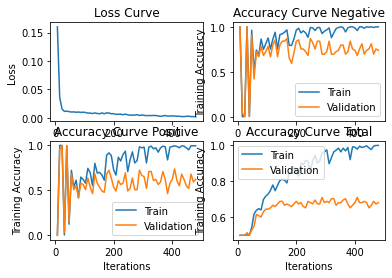

Final Negative Training Accuracy: 1.0
Final Negative Validation Accuracy: 0.7391304347826086
Final Positive Training Accuracy: 0.9962546816479401
Final Positive Validation Accuracy: 0.6231884057971014


<Figure size 432x288 with 0 Axes>

In [ ]:
model = CNNChannel(8)
  
train_model(model, train_data,valid_data, batch_size=64, weight_decay=0.04,
        learning_rate=0.0001, num_epochs=60, loss_plot = True, neg_plot= True, pos_plot = True, tot_plot = True, verbose = True)
  
plt.tight_layout()
plt.show()